In [6]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as emb
from dwave.samplers import SimulatedAnnealingSampler
import dimod
from scipy.sparse import lil_matrix, csc_matrix, block_diag

In [2]:
def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = sorted(event.modules, key=lambda module: module.z)

    
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]

    N = len(segments)  

    #initialize sparse block matrices for effviciency
    A_ang_blocks = []
    A_bif_blocks = []
    A_inh_blocks = []
    b = np.zeros(N)

    #total Hamiltonian into smaller blocks->> better for memory
    block_size = 500  
    num_blocks = (N + block_size - 1) // block_size  

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)

        #lil_matrix for each block
        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_inh_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        #filling of papricas
        for i in range(start_idx, end_idx):
            seg_i = segments[i]
            vect_i = seg_i.to_vect()
            norm_i = np.linalg.norm(vect_i)

            for j in range(i + 1, end_idx):  #
                seg_j = segments[j]
                vect_j = seg_j.to_vect()
                norm_j = np.linalg.norm(vect_j)

                cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
                if np.abs(cosine - 1) < 1e-9:
                    A_ang_block[i - start_idx, j - start_idx] = 1
                    A_ang_block[j - start_idx, i - start_idx] = 1  # Symmetry with positive sign

                if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                if seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                    A_bif_block[i - start_idx, j - start_idx] = -alpha
                    A_bif_block[j - start_idx, i - start_idx] = -alpha  # Symmetry with negative sign

                s_ab = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
                if s_ab > 0:
                    A_inh_block[i - start_idx, j - start_idx] = beta * s_ab * s_ab
                    A_inh_block[j - start_idx, i - start_idx] = beta * s_ab * s_ab  # Symmetry with positive sign

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)
        A_inh_blocks.append(A_inh_block)

    # combine withblock diagonal
    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')
    A_inh = block_diag(A_inh_blocks, format='csc')

    A = -1 * (A_ang + A_bif + A_inh)

    return A, b, segments
def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = copy.deepcopy(event.modules)
    modules.sort(key=lambda a: a.z)

    segments = [em.segment(from_hit, to_hit) for idx in range(len(modules) - 1) for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)]
    N = len(segments)
    A = np.zeros((N, N))
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    
    b = np.zeros(N)

    s_ab = np.zeros((N, N))
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            s_ab[i, j] = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
    A_inh = np.zeros((N, N))

    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            if i != j:
                vect_i = seg_i.to_vect()
                vect_j = seg_j.to_vect()
                cosine = np.dot(vect_i, vect_j) / (np.linalg.norm(vect_i) * np.linalg.norm(vect_j))

                eps = 1e-9

                if np.abs(cosine - 1) < eps:
                    A_ang[i, j] = 1

                if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                    A_bif[i, j] = -alpha

                if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                    A_bif[i, j] = -alpha

                A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Compute the final expression
    A = -1 * (A_ang + A_bif + A_inh)

    components = {'A_ang': -A_ang, 'A_bif': -A_bif, 'A_inh': -A_inh}

    return A, b, components, segments

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 

In [12]:
import tracemalloc
import time
import psutil
import matplotlib.pyplot as plt

# Measure memory usage with tracemalloc
def measure_memory(func, *args):
    tracemalloc.start()
    func(*args)
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak

# Measure time usage
def measure_time(func, *args):
    start = time.time()
    func(*args)
    end = time.time()
    return end - start

# Measure CPU-based energy consumption (approximation using CPU times)
def measure_energy(process):
    cpu_times = process.cpu_times()
    # Approximate energy usage by CPU time (user + system)
    return (cpu_times.user + cpu_times.system) * 10  # 10 Joules per second of CPU time (approx)

# Performance test for both optimized and non-optimized functions
def performance_test(input_size):
    process = psutil.Process()

    # Optimized function performance
    memory_opt = measure_memory(generate_hamiltonian_optimized, input_size)
    time_opt = measure_time(generate_hamiltonian_optimized, input_size)
    energy_opt = measure_energy(process)

    # Non-Optimized function performance
    memory_non_opt = measure_memory(generate_hamiltonian, input_size)
    time_non_opt = measure_time(generate_hamiltonian, input_size)
    energy_non_opt = measure_energy(process)

    return (memory_opt, time_opt, energy_opt, memory_non_opt, time_non_opt, energy_non_opt)


In [ ]:
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import lil_matrix, block_diag
import tracemalloc

def generate_hamiltonian(N):
    A = np.zeros((N, N))
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    b = np.zeros(N)

    for i in range(N):
        for j in range(N):
            if i != j:
                # Simulate operatios for ang and biff term
                A_ang[i, j] = 1 if np.random.rand() > 0.5 else 0
                A_bif[i, j] = -1 if np.random.rand() > 0.5 else 0

    A = -1 * (A_ang + A_bif)

    return A, b

def generate_hamiltonian_optimized(N):
    block_size = 500
    num_blocks = (N + block_size - 1) // block_size

    A_ang_blocks = []
    A_bif_blocks = []
    b = np.zeros(N)

    for block_idx in range(num_blocks):
        start_idx = block_idx * block_size
        end_idx = min(start_idx + block_size, N)

        A_ang_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)
        A_bif_block = lil_matrix((end_idx - start_idx, end_idx - start_idx), dtype=np.float32)

        for i in range(start_idx, end_idx):
            for j in range(i + 1, end_idx):
                A_ang_block[i - start_idx, j - start_idx] = 1 if np.random.rand() > 0.5 else 0
                A_bif_block[i - start_idx, j - start_idx] = -1 if np.random.rand() > 0.5 else 0

        A_ang_blocks.append(A_ang_block)
        A_bif_blocks.append(A_bif_block)

    A_ang = block_diag(A_ang_blocks, format='csc')
    A_bif = block_diag(A_bif_blocks, format='csc')

    A = -1 * (A_ang + A_bif)

    return A, b

#helper function to measure execution time and memory 
def measure_performance(func, N):
    try:
        tracemalloc.start()

        start_time = time.time()
        snapshot1 = tracemalloc.take_snapshot()
        func(N)

    
        snapshot2 = tracemalloc.take_snapshot()
        end_time = time.time()

        tracemalloc.stop()

        stats = snapshot2.compare_to(snapshot1, 'lineno')
        total_memory = sum([stat.size_diff for stat in stats]) / (1024 ** 2)  # Convert to MB
        time_taken = end_time - start_time

        return time_taken, total_memory

    except MemoryError:
        print(f"MemoryError for size {N}")
        return None, None
input_sizes = [100, 1000, 5000, 10000, 20000, 50000, 100000, 160000, 200000]  # Adjust or add more sizes as needed
times_non_opt = []
times_opt = []
mem_non_opt = []
mem_opt = []

for size in input_sizes:
    print(f"Testing size: {size}x{size}")
    
    time_non_opt, mem_non_opt_used = measure_performance(generate_hamiltonian, size)
    times_non_opt.append(time_non_opt)
    mem_non_opt.append(mem_non_opt_used)

    time_opt, mem_opt_used = measure_performance(generate_hamiltonian_optimized, size)
    times_opt.append(time_opt)
    mem_opt.append(mem_opt_used)

times_non_opt = [t if t is not None else float('nan') for t in times_non_opt]
times_opt = [t if t is not None else float('nan') for t in times_opt]
mem_non_opt = [m if m is not None else float('nan') for m in mem_non_opt]
mem_opt = [m if m is not None else float('nan') for m in mem_opt]

plt.figure(figsize=(10, 6))
plt.plot(input_sizes, times_non_opt, label='Non-Optimized', marker='o')
plt.plot(input_sizes, times_opt, label='Optimized', marker='o')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time vs Matrix Size')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(input_sizes, mem_non_opt, label='Non-Optimized', marker='o')
plt.plot(input_sizes, mem_opt, label='Optimized', marker='o')
plt.xlabel('Matrix Size (N x N)')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage vs Matrix Size')
plt.legend()
plt.grid(True)
plt.show()


Testing size: 100x100
Testing size: 1000x1000
Testing size: 5000x5000
Testing size: 10000x10000
Testing size: 20000x20000
MemoryError for size 20000
Testing size: 50000x50000
MemoryError for size 50000
Testing size: 100000x100000
MemoryError for size 100000
Testing size: 160000x160000
MemoryError for size 160000


MemoryError occurred: Unable to allocate 18.6 GiB for an array with shape (2500000000,) and data type int64. Continuing with plotting results obtained so far...
   Matrix Size (N)  Non-Optimized Time (s)  Non-Optimized Memory (MB)  \
0              100                0.220450                   0.011719   
1              500                1.376620                   0.003906   
2             1000                3.093604                   0.726562   
3             5000               43.859929                  41.109375   
4            10000              120.763007                 175.859375   
5            20000              368.860854                 600.769531   

   Optimized Time (s)  Optimized Memory (MB)  
0            0.186230               0.000000  
1            1.325155               0.000000  
2            3.354952               0.054688  
3           46.922501               4.726562  
4          127.335666              16.785156  
5          417.006497             137.988281 

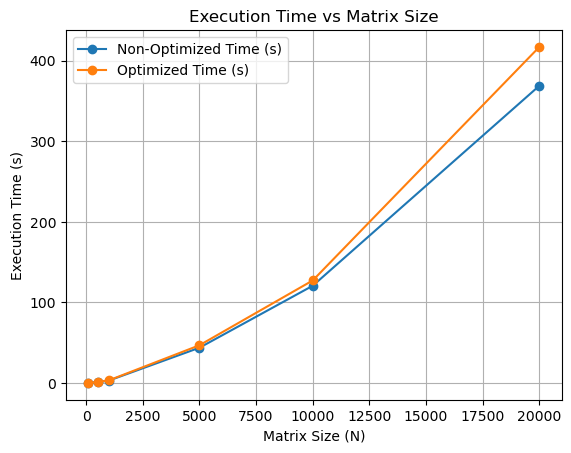

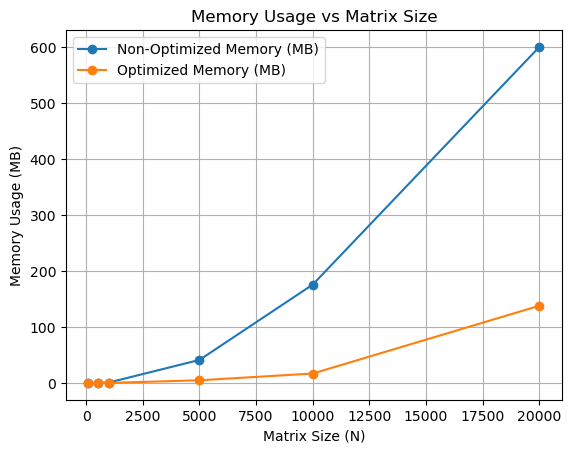

In [19]:
import time
import psutil
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random as sparse_random, csc_matrix
from dwave.samplers import SimulatedAnnealingSampler
import dimod
import pandas as pd


def qubosolver_non_optimized(A, b):
    process = psutil.Process() 
    start_time = time.time()
    start_memory = process.memory_info().rss / (1024 ** 2) 

    matrix_A = np.array(A.toarray()) 
    
    bqm = dimod.BinaryQuadraticModel(b, matrix_A, 0.0, dimod.BINARY)
    q, off = bqm.to_qubo()

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample_qubo(q, num_reads=100)
    best_sample = response.first.sample
    sol_sample = np.array(list(best_sample.values()))

    end_time = time.time()
    end_memory = process.memory_info().rss / (1024 ** 2)  

    time_taken = end_time - start_time
    memory_used = end_memory - start_memory

    return sol_sample, time_taken, memory_used

def qubosolver_optimized(A, b):
    process = psutil.Process()
    start_memory = process.memory_info().rss / (1024 ** 2)  
    start_time = time.time()

    A = csc_matrix(A)  
    bqm = dimod.BinaryQuadraticModel.empty(dimod.BINARY)
    bqm.add_variables_from({i: b[i] for i in range(len(b))})

    row, col = A.nonzero()
    for i, j in zip(row, col):
        if i != j:
            bqm.add_interaction(i, j, A[i, j])

    sampler = SimulatedAnnealingSampler()
    response = sampler.sample(bqm, num_reads=100)
    best_sample = response.first.sample
    sol_sample = np.fromiter(best_sample.values(), dtype=int)

    end_time = time.time()
    end_memory = process.memory_info().rss / (1024 ** 2) 
    time_taken = end_time - start_time
    memory_used = end_memory - start_memory

    return sol_sample, time_taken, memory_used

def generate_sparse_binary_matrix_and_vector(N, density=0.01):
    density = max(density, 1 / N)  
    A = sparse_random(N, N, density=density, format='csc', dtype=np.int8)  #sparse binary matrix
    A.data[:] = np.random.randint(2, size=A.nnz) 
    if A.nnz == 0:
        raise ValueError(f"Generated matrix A with size {A.shape} contains no non-zero elements. Try increasing density.")
    
    b = np.random.randint(2, size=N) 
    return A, b

def compare_performance(matrix_sizes):
    results = []
    stop_testing_non_optimized = False  #stop testing if memoryissues
    stop_testing_optimized = False  
    try:
        for N in matrix_sizes:
            try:
                A, b = generate_sparse_binary_matrix_and_vector(N, density=0.01)
            except ValueError as e:
                print(f"Error generating matrix for size {N}: {e}")
                continue  

            time_non_opt, memory_non_opt = None, None
            if not stop_testing_non_optimized:
                try:
                    _, time_non_opt, memory_non_opt = qubosolver_non_optimized(A, b)
                except MemoryError as e:
                    print(f"MemoryError in non-optimized solver for matrix size {N}: {e}")
                    stop_testing_non_optimized = True

            time_opt, memory_opt = None, None
            if not stop_testing_optimized:
                try:
                    _, time_opt, memory_opt = qubosolver_optimized(A, b)
                except MemoryError as e:
                    print(f"MemoryError in optimized solver for matrix size {N}: {e}")
                    stop_testing_optimized = True  


            results.append({
                'Matrix Size (N)': N,
                'Non-Optimized Time (s)': time_non_opt,
                'Non-Optimized Memory (MB)': memory_non_opt,
                'Optimized Time (s)': time_opt,
                'Optimized Memory (MB)': memory_opt,
            })

    except MemoryError as e:
        print(f"MemoryError occurred: {e}. Continuing with plotting results obtained so far...")

#plotingstuff
    df = pd.DataFrame(results)
    print(df)  

    plt.figure()
    if df['Non-Optimized Time (s)'].notna().any():
        plt.plot(df['Matrix Size (N)'], df['Non-Optimized Time (s)'], label='Non-Optimized Time (s)', marker='o')
    if df['Optimized Time (s)'].notna().any():
        plt.plot(df['Matrix Size (N)'], df['Optimized Time (s)'], label='Optimized Time (s)', marker='o')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time vs Matrix Size')
    plt.legend()
    plt.grid(True)
    plt.show()
    plt.figure()
    if df['Non-Optimized Memory (MB)'].notna().any():
        plt.plot(df['Matrix Size (N)'], df['Non-Optimized Memory (MB)'], label='Non-Optimized Memory (MB)', marker='o')
    if df['Optimized Memory (MB)'].notna().any():
        plt.plot(df['Matrix Size (N)'], df['Optimized Memory (MB)'], label='Optimized Memory (MB)', marker='o')
    plt.xlabel('Matrix Size (N)')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage vs Matrix Size')
    plt.legend()
    plt.grid(True)
    plt.show()

matrix_sizes = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000, 160000 ]  # Adjust sizes gradually based on system capacity
compare_performance(matrix_sizes)
